In [1]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.extensions import UnitaryGate
import numpy as np
import sys 
sys.path.append("..")

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.3', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
from Modules.kitaev_qpe import KQPE

### Tesing Kitaev Circuit for 1-qubit 

In [4]:
U = np.array([[1, 0],
              [0, np.exp(2*np.pi*1j*(1/3))]])

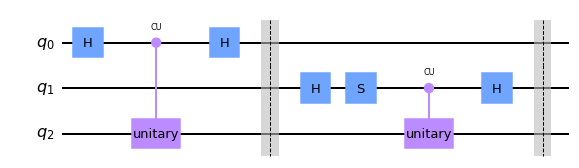

In [5]:
kqpe = KQPE(unitary=U, precision=16)
kq_circ = kqpe.get_circuit(show=True, save_circ=True,
                           circ_name="KQPE_circ_1qubit.JPG")

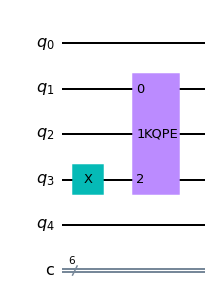

In [6]:
q = QuantumCircuit(5, 6)
q.x(3)
q.append(kq_circ, qargs=[1, 2, 3])
q.draw('mpl')

Shots : 655360


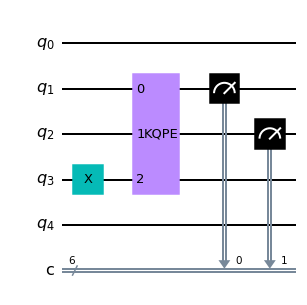

Measurement results : {'000011': 458884, '000010': 152593, '000001': 32863, '000000': 11020}


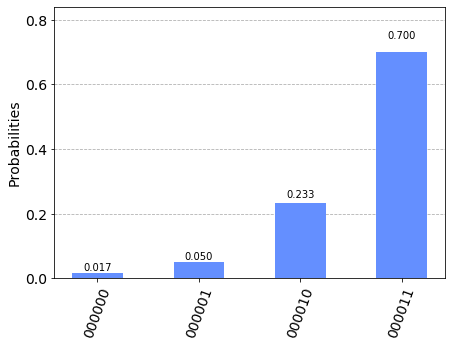

In [7]:
phase = kqpe.get_phase(backend=Aer.get_backend(
    'qasm_simulator'), QC=q, ancilla=[1, 2], clbits=[0, 1], show=True)

In [8]:
print("Phase of the unitary is :", phase)

Phase of the unitary is : (0.33342445890879113, [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1])


### Testing Kitaev for 2-qubits
- Making a Controlled phase gate with phase as 1/7
- The eigenvector is $ |11\rangle$

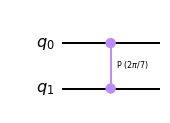

In [9]:
q = QuantumCircuit(2, name='Unitary')
q.cp(2*np.pi*(1/7), 0, 1)
q.draw('mpl')

In [10]:
unitary = q

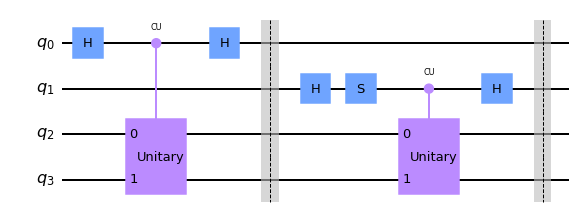

In [11]:
kqpe = KQPE(unitary, precision=12)
kq_circ = kqpe.get_circuit(show=True)

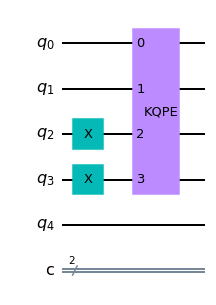

In [12]:
q = QuantumCircuit(5, 2)
q.x([2, 3])
q.append(kq_circ, qargs=[0, 1, 2, 3])
q.draw('mpl')

In [13]:
sim = Aer.get_backend('qasm_simulator')

Shots : 40960


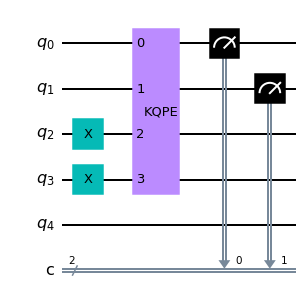

Measurement results : {'10': 29551, '11': 6869, '00': 3686, '01': 854}


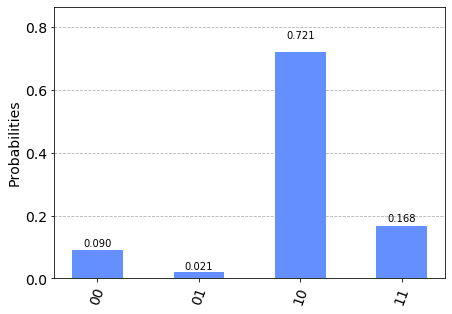

In [14]:
phase = kqpe.get_phase(backend=sim, QC=q, ancilla=[
                       0, 1], clbits=[0, 1], show=True)

In [15]:
print("Phase returned is :", phase)

Phase returned is : (0.14258120746233371, [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0])


- Let us plot a graph with the returned phase and see how close this estimate is to the actual eigenvalue of the matrix being measured

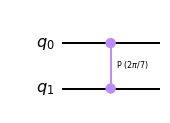

In [16]:
q = QuantumCircuit(2, name='Phase Unitary')
q.cp(2*np.pi*(1/7), 0, 1)
display(q.draw('mpl'))
unitary = q

In [17]:
precision = [i for i in range(8, 18)]
precision

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [18]:
estimates, errors = [], []
for prec in precision:
    kqpe = KQPE(unitary, precision=prec)
    kq_circ = kqpe.get_circuit(show=False)

    # making circuit
    q = QuantumCircuit(5, 2)
    q.x([2, 3])
    q.append(kq_circ, qargs=[0, 1, 2, 3])

    # getting the phase
    phase = kqpe.get_phase(backend=sim, QC=q, ancilla=[
                           0, 1], clbits=[0, 1], show=False)
    estimates.append(phase[0])
    errors.append(abs(1/7-phase[0]))

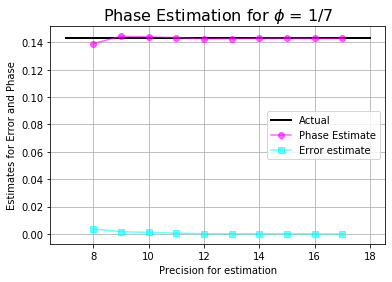

In [19]:
import matplotlib.pyplot as plt
plt.title("Phase Estimation for $ \phi $ = 1/7", fontsize=16)
plt.xlabel("Precision for estimation")
plt.ylabel("Estimates for Error and Phase")
plt.plot([7, 18], [1/7, 1/7], color='black', label='Actual', linewidth=2)
plt.plot(precision, estimates, marker='o', color='magenta',
         alpha=0.6, label='Phase Estimate')
plt.plot(precision, errors, marker='s', color='cyan',
         alpha=0.6, label="Error estimate")
plt.grid()
plt.legend()
plt.savefig("Kitaev Multiqubit Estimation Plot.JPG", dpi=200)